# Classification des documents du procès des groupes américains du tabac

### Bibliothèques nécessaires

In [1]:
# libraries for dataset preparation, feature engineering, model training 
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, linear_model, svm
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import ast
import os
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten, BatchNormalization, GlobalMaxPool1D
from keras.models import Model, Sequential

import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.preprocessing import text, sequence
import seaborn as sns
%matplotlib inline


C:\Users\Ilyas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Préparation des données

In [2]:
def data_preper(PATH_data, del_saut_line):
    
    """ Inputs : * PATH_data --> type str, chemin du dossier contenant les 10 dossiers de donnees.
                 * del_saut_line --> type bool, si True, on récupère nos donnees texte sans le saut de ligne '\n'.
        Outputs: * Data frame, Contenant deux colonnes, une correspond au textes, et l'autre au labels. """
    
    classes = []
    filenames = []
    X = []
    y = []
    
    # Parcours du dossier contenant les 10 dossiers correspondants au classes
    for i, classe in enumerate (os.listdir(PATH_data)):
        
        inputFilepath = classe
        filename_w_ext = os.path.basename(inputFilepath)
        filename, file_extension = os.path.splitext(filename_w_ext)
        classes.append(filename)
        path = PATH_data + '/' + filename

        # Parcours de chaque dossier pour extraire le texte de chaque fichier
        for j, element in enumerate (os.listdir(path)):
            inputFilepath = element
            filename_w_ext = os.path.basename(inputFilepath)
            filename, file_extension = os.path.splitext(filename_w_ext)
            filenames.append(filename)
            path_file = path + '/' + element
            
            file = open(path_file,'r',encoding='utf8').read()
            if del_saut_line == True:
                text = ""
                for k, line in enumerate(file.split("\n")):
                    content = line.split()
                    text += (" ".join(content[1:]))
                X.append(text)
                y.append(classes[i])
                
            if del_saut_line == False:
                X.append(file)
                y.append(classes[i])

    y = np.asarray(y)
    X = np.asarray(X)
    
    # create a dataframe using texts and lables
    df = pd.DataFrame()
    df['text'] = X
    df['label'] = y
    
    return(df)


Nombre de donnees:  3482

Exemple du dataframe avec saut de ligne:
                                                   text          label
220  ce\n\n  \n\nNew: Laser-Cut “Flavor Chamber”\n\...  Advertisement
221  THE IMAGINATION To Sez It,\nTHE Passion To Pur...  Advertisement
222  NIORE\nPACKINGS.\n\nIIORE\nPLEASURE.\n\nee\nNe...  Advertisement
223  SURGEON GENERAL'S WARNING: Smoking\nCauses Lun...  Advertisement
224  SURGEON GENERAL'S WARNING: Cigarette\nSmoke Co...  Advertisement
225  Helping Youth Say No” is only one part of wide...  Advertisement
226  Senge,\n\n~  SOYOUDONT |\nSMOKE!\n\n \n\n~ .\n...  Advertisement
227  The tobacco industry is committed to seeing th...  Advertisement
228  S\n2\n\ns\n\n \n\n~HOLD FOR OUR INDUSTRY?\n\n»...  Advertisement
229  Yon CE MOTE PSU AQ YN IS MLE\n\nALALILSNI ODDV...  Advertisement
230  Ellis, Cathy L. (WSA)\n\n \n\nFrom: Hsu, Frank...          Email
231  Pabst, Joanne\n\n \n\nFrom: Keane, Denise\n\nS...          Email
232  — Original Messa

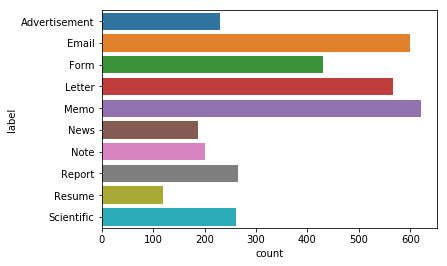

In [3]:
# preparation des donnees sans enlever '/n'

PATH_data = 'C:/Users/Ilyas/Desktop/M2 SID - SD/Text Analysis/nlp-labs/tobacco-lab/data'
df = data_preper(PATH_data, del_saut_line=False)

sns.countplot(data=df,y='label')

print('\nNombre de donnees: ',df['text'].shape[0])
print('\nExemple du dataframe avec saut de ligne:\n',df[220:240])

In [4]:
X_app, X_test, y_app, y_test = train_test_split(df['text'], df['label'], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_app, y_app, test_size=0.1)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_val = encoder.fit_transform(y_val)
y_app = encoder.fit_transform(y_app)

print('\nNombre de donnees: ',df['text'].shape[0])
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('X_val: ',X_val.shape)


Nombre de donnees:  3482
X_train:  (2819,)
X_test:  (349,)
X_val:  (314,)


### Feature Engineering

##### Count Vectors as features : 

In [5]:
# Create document vectors
vectorizer = CountVectorizer(max_features=3000,analyzer='word', token_pattern=r'\w{1,}')
vectorizer.fit(df['text'])

X_train_counts = vectorizer.transform(X_train)
X_val_counts = vectorizer.transform(X_val)
X_test_counts = vectorizer.transform(X_test)

##### TF-idf Vectors as features 

In [6]:
# N-gram level tf-idf:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,4), max_features=1000)
tfidf_vect.fit(df['text'])

X_train_tf =  tfidf_vect.transform(X_train)
X_val_tf =  tfidf_vect.transform(X_val)
X_test_tf = tfidf_vect.transform(X_test)

### Model Building 

##### Naive Bayes Classifier

- With Count Vectors representation

In [7]:
# train a Naive Bayes classifier:
clf = MultinomialNB()
clf.fit(X_train_counts,y_train)
score_val = clf.score(X_val_counts,y_val)
print(' - Validation du classifieur: \n')
print('Score : ',score_val)

# predict test classes:
print('\n - Prediction des classes et test sur les donnees de test: \n')
y_pred = clf.predict(X_test_counts)
print(classification_report(y_test, y_pred))
print('matrice de confusion : \n',confusion_matrix(y_test, y_pred))


 - Validation du classifieur: 

Score :  0.7356687898089171

 - Prediction des classes et test sur les donnees de test: 

             precision    recall  f1-score   support

          0       0.70      0.70      0.70        23
          1       0.98      0.94      0.96        63
          2       0.74      0.90      0.81        48
          3       0.81      0.68      0.74        65
          4       0.66      0.78      0.71        51
          5       0.71      0.83      0.77        18
          6       0.38      0.33      0.36        15
          7       0.60      0.46      0.52        26
          8       1.00      1.00      1.00        15
          9       0.67      0.64      0.65        25

avg / total       0.76      0.76      0.76       349

matrice de confusion : 
 [[16  0  0  0  2  0  4  1  0  0]
 [ 0 59  0  1  2  1  0  0  0  0]
 [ 2  0 43  1  0  0  1  0  0  1]
 [ 0  1  5 44  5  4  1  4  0  1]
 [ 0  0  2  6 40  0  1  2  0  0]
 [ 2  0  0  0  0 15  1  0  0  0]
 [ 2  0  3  0  5

- With TF-IDF Vectors representation

In [8]:
# train a Naive Bayes classifier:
clf = MultinomialNB()
clf.fit(X_train_tf,y_train)
score_val = clf.score(X_val_tf,y_val)
print('score : ',score_val)

# predict test classes:
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))
print('matrice de confusion : \n',confusion_matrix(y_test, y_pred))

score :  0.7261146496815286
             precision    recall  f1-score   support

          0       0.84      0.70      0.76        23
          1       0.97      0.95      0.96        63
          2       0.65      0.96      0.77        48
          3       0.80      0.74      0.77        65
          4       0.64      0.80      0.71        51
          5       0.79      0.83      0.81        18
          6       1.00      0.07      0.12        15
          7       0.58      0.27      0.37        26
          8       1.00      1.00      1.00        15
          9       0.65      0.68      0.67        25

avg / total       0.78      0.76      0.74       349

matrice de confusion : 
 [[16  0  3  0  4  0  0  0  0  0]
 [ 0 60  0  1  1  1  0  0  0  0]
 [ 1  0 46  1  0  0  0  0  0  0]
 [ 0  1  4 48  6  0  0  3  0  3]
 [ 0  0  3  6 41  0  0  1  0  0]
 [ 2  0  1  0  0 15  0  0  0  0]
 [ 0  0  8  1  5  0  1  0  0  0]
 [ 0  1  1  3  5  3  0  7  0  6]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  5 

##### Linear Classifier

- With Count Vectors representation

In [9]:
# train a Linear classifier:
lc = linear_model.LogisticRegression()
lc.fit(X_train_counts,y_train)
score_val = lc.score(X_val_counts,y_val)
print(' - Validation du classifieur: \n')
print('Score : ',score_val)

# predict test classes:
print('\n - Prediction des classes et test sur les donnees de test: \n')
y_pred = lc.predict(X_test_counts)
print(classification_report(y_test, y_pred))
print('matrice de confusion : \n',confusion_matrix(y_test, y_pred))

 - Validation du classifieur: 

Score :  0.7929936305732485

 - Prediction des classes et test sur les donnees de test: 

             precision    recall  f1-score   support

          0       0.79      0.65      0.71        23
          1       0.94      0.98      0.96        63
          2       0.83      0.92      0.87        48
          3       0.84      0.78      0.81        65
          4       0.75      0.84      0.80        51
          5       0.88      0.83      0.86        18
          6       0.57      0.80      0.67        15
          7       0.75      0.46      0.57        26
          8       1.00      1.00      1.00        15
          9       0.67      0.64      0.65        25

avg / total       0.82      0.82      0.81       349

matrice de confusion : 
 [[15  1  1  0  1  0  5  0  0  0]
 [ 0 62  0  1  0  0  0  0  0  0]
 [ 1  0 44  1  0  0  2  0  0  0]
 [ 1  1  1 51  7  1  0  1  0  2]
 [ 1  0  0  6 43  0  1  0  0  0]
 [ 1  1  0  0  0 15  0  0  0  1]
 [ 0  0  2  0  1

- With TF-IDF Vectors representation

In [10]:
# train a Linear classifier:
lc = linear_model.LogisticRegression()
lc.fit(X_train_tf,y_train)
score_val = lc.score(X_val_tf,y_val)
print('score : ',score_val)

# predict test classes:
y_pred = lc.predict(X_test_tf)
print(classification_report(y_test, y_pred))
print('matrice de confusion : \n',confusion_matrix(y_test, y_pred))

score :  0.7738853503184714
             precision    recall  f1-score   support

          0       0.76      0.57      0.65        23
          1       0.95      0.95      0.95        63
          2       0.72      0.88      0.79        48
          3       0.87      0.74      0.80        65
          4       0.72      0.84      0.77        51
          5       0.76      0.89      0.82        18
          6       0.56      0.67      0.61        15
          7       0.64      0.35      0.45        26
          8       1.00      1.00      1.00        15
          9       0.61      0.68      0.64        25

avg / total       0.79      0.78      0.78       349

matrice de confusion : 
 [[13  0  2  0  3  1  4  0  0  0]
 [ 0 60  0  1  1  1  0  0  0  0]
 [ 2  0 42  0  0  0  3  0  0  1]
 [ 1  1  4 48  5  1  0  3  0  2]
 [ 0  1  1  5 43  0  0  1  0  0]
 [ 1  0  1  0  0 16  0  0  0  0]
 [ 0  0  3  0  2  0 10  0  0  0]
 [ 0  1  1  1  4  2  0  9  0  8]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  4 

##### Bagging Models

In [11]:
# train a bagging model:
clf = tree.DecisionTreeClassifier(max_depth=100)      # 100 arbres
bagging = BaggingClassifier(clf,max_samples=0.5, max_features=0.5)
bagging.fit(X_train_tf,y_train)
score_val = bagging.score(X_val_tf,y_val)
print('score : ',score_val)

# predict test classes:
y_pred = bagging.predict(X_test_tf)
print(classification_report(y_test, y_pred))
print('matrice de confusion : \n',confusion_matrix(y_test, y_pred))

score :  0.7420382165605095
             precision    recall  f1-score   support

          0       0.70      0.70      0.70        23
          1       0.91      0.97      0.94        63
          2       0.65      0.83      0.73        48
          3       0.80      0.78      0.79        65
          4       0.81      0.76      0.79        51
          5       0.82      0.78      0.80        18
          6       0.57      0.53      0.55        15
          7       0.44      0.27      0.33        26
          8       1.00      1.00      1.00        15
          9       0.65      0.60      0.63        25

avg / total       0.76      0.76      0.76       349

matrice de confusion : 
 [[16  0  2  1  0  0  3  1  0  0]
 [ 0 61  0  1  0  0  0  1  0  0]
 [ 1  2 40  0  1  0  1  2  0  1]
 [ 0  1  4 51  5  0  1  2  0  1]
 [ 1  2  2  6 39  0  0  1  0  0]
 [ 2  0  2  0  0 14  0  0  0  0]
 [ 2  1  3  1  0  0  8  0  0  0]
 [ 0  0  5  3  2  3  0  7  0  6]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 1  0  4 

##### Reseau de neuronnes convoltionnel (CNN)

In [12]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES, )

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)

def get_model():

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_TEXT_LENGTH, EMBED_SIZE)(inp)
    
    model = Conv1D(filters=64, kernel_size=7, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=3)(model)
    model = BatchNormalization(axis=1)(model)
    model = Dropout(0.25)(model)
    
    model = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=5)(model)
    model = BatchNormalization(axis=1)(model)
    model = Dropout(0.3)(model)
    
    model = Flatten()(model)
    model = Dense(1024, activation="relu")(model)
    model = Dense(10, activation="softmax")(model)
    
    model = Model(inputs=inp, outputs=model)
    
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.summary()
    
    return model


In [13]:
# Model parameters

MAX_FEATURES = 500
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = 32
BATCH_SIZE = 64
EPOCHS = 50
VALIDATION_SPLIT = 0.1

# Get the list of different classes
CLASSES_LIST = np.unique(y_app)
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert class string to index
train_y_cat = np_utils.to_categorical(y_app, n_out)
test_y_cat = np_utils.to_categorical(y_test, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(X_app, X_test)
print(len(x_vec_train), len(x_vec_test))

# define the NN topology
model = get_model()

# Create callbacks
filepath = 'model_cnn' + '.hdf5'
multi_checkpointer = ModelCheckpoint(filepath=filepath, verbose=0)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.2)

# Train 
model.fit(x_vec_train, train_y_cat,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1, validation_split=VALIDATION_SPLIT,callbacks=[multi_checkpointer,multi_lr_reduction])


[0 1 2 3 4 5 6 7 8 9]
3133 349
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           16000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           14400     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 166, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 166, 64)           664       
_________________________________________________________________
dropout_1 (Dropout)          (None, 166, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 166, 128)

In [15]:
# Matrice de probabilitées d'appartenance à chaque classe
y_predicted = model.predict(x_vec_test)

# Attribution de la classe qui a la plus probable
y_pred = np.zeros(len(y_test))
for i in range(len(y_predicted)):
    y_pred[i] = np.argmax(y_predicted[i])

print("Test Accuracy:", accuracy_score(y_test, y_pred))

p, r, f1, s = precision_recall_fscore_support(y_test, y_pred, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_pred, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

Test Accuracy: 0.7621776504297995
p r f1 76.2 76.22 76.218
             precision    recall  f1-score   support

          0       0.69      0.48      0.56        23
          1       0.98      0.94      0.96        63
          2       0.73      0.85      0.79        48
          3       0.84      0.66      0.74        65
          4       0.71      0.90      0.79        51
          5       0.79      0.83      0.81        18
          6       0.55      0.73      0.63        15
          7       0.42      0.42      0.42        26
          8       1.00      0.93      0.97        15
          9       0.68      0.60      0.64        25

avg / total       0.77      0.76      0.76       349

